In [1]:
!wget "https://he-public-data.s3.ap-southeast-1.amazonaws.com/shell_dataset.zip"

--2021-11-07 04:23:56--  https://he-public-data.s3.ap-southeast-1.amazonaws.com/shell_dataset.zip
Resolving he-public-data.s3.ap-southeast-1.amazonaws.com (he-public-data.s3.ap-southeast-1.amazonaws.com)... 52.219.40.15
Connecting to he-public-data.s3.ap-southeast-1.amazonaws.com (he-public-data.s3.ap-southeast-1.amazonaws.com)|52.219.40.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3467218047 (3.2G) [binary/octet-stream]
Saving to: ‘shell_dataset.zip’

shell_dataset.zip   100%[===================>]   3.23G  17.0MB/s    in 3m 15s  

2021-11-07 04:27:12 (16.9 MB/s) - ‘shell_dataset.zip’ saved [3467218047/3467218047]



In [2]:
!unzip -q "shell_dataset.zip"
!unzip -q "dataset/train.zip"
!unzip -q "dataset/test.zip"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
tdf = pd.read_csv('dataset/test.csv')

In [3]:
tdf = tdf.set_index('scenario_set')

In [4]:
tdf

,30_min_horizon,60_min_horizon,90_min_horizon,120_min_horizon
scenario_set,,,,
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
...,...,...,...,...
296,NaN,NaN,NaN,NaN
297,NaN,NaN,NaN,NaN
298,NaN,NaN,NaN,NaN


In [5]:
path = 'test/'+str(29)+'/weather_data.csv'
df = pd.read_csv(path)

In [6]:
df.corr()['Total Cloud Cover [%]']

Time [Mins]                             -0.138111
Global CMP22 (vent/cor) [W/m^2]         -0.044983
Direct sNIP [W/m^2]                      0.164914
Azimuth Angle [degrees]                 -0.268129
Tower Dry Bulb Temp [deg C]             -0.124148
Tower Wet Bulb Temp [deg C]              0.013955
Tower Dew Point Temp [deg C]             0.128513
Tower RH [%]                             0.399391
Total Cloud Cover [%]                    1.000000
Peak Wind Speed @ 6ft [m/s]              0.038641
Avg Wind Direction @ 6ft [deg from N]   -0.066933
Station Pressure [mBar]                  0.468071
Precipitation (Accumulated) [mm]              NaN
Snow Depth [cm]                         -0.138905
Moisture                                      NaN
Albedo (CMP11)                          -0.067667
Name: Total Cloud Cover [%], dtype: float64

In [7]:
todays_date = datetime.now().date()
index = pd.date_range('2020-01-01 00:00:00', periods=361, freq='1min')
df = df.set_index(index[0:361])
df.drop('Time [Mins]',inplace=True,axis=1)


In [8]:
df

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
2020-01-01 00:00:00,65.0694,367.475,68.72871,15.85,11.477,8.577,61.95,10,1.95,308.2,825.645,0.0,0.116,0.0,0.3472
2020-01-01 00:01:00,67.4601,374.735,68.88137,15.87,11.484,8.584,61.90,10,1.70,308.1,825.625,0.0,0.107,0.0,0.3446
2020-01-01 00:02:00,69.9504,382.390,69.03386,15.87,11.543,8.643,62.15,10,1.95,300.6,825.594,0.0,0.120,0.0,0.3414
2020-01-01 00:03:00,72.6125,390.961,69.18619,15.89,11.472,8.572,61.77,10,1.45,301.8,825.594,0.0,0.085,0.0,0.3379
2020-01-01 00:04:00,75.2571,399.052,69.33836,15.89,11.569,8.669,62.18,10,1.95,310.0,825.592,0.0,0.039,0.0,0.3338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 05:56:00,968.6070,918.855,152.86379,25.55,17.512,13.542,47.41,7,3.70,123.8,824.643,0.0,0.552,0.0,0.1531
2020-01-01 05:57:00,972.1870,922.428,153.45752,25.25,17.415,13.525,48.21,7,2.95,125.0,824.650,0.0,0.702,0.0,0.1533
2020-01-01 05:58:00,972.9660,922.297,154.05542,25.21,17.098,12.998,46.69,8,2.70,114.7,824.655,0.0,0.659,0.0,0.1530
2020-01-01 05:59:00,970.4790,917.691,154.65745,25.21,16.991,12.791,46.06,9,1.95,116.1,824.663,0.0,0.414,0.0,0.1531


In [9]:
df = df.resample('5min').min()

In [10]:
df['Total Cloud Cover [%]'] = [np.NaN if (per < 0 or per > 100) else per for per in df['Total Cloud Cover [%]']]

In [11]:
df['Total Cloud Cover [%]'] = df['Total Cloud Cover [%]'].interpolate()

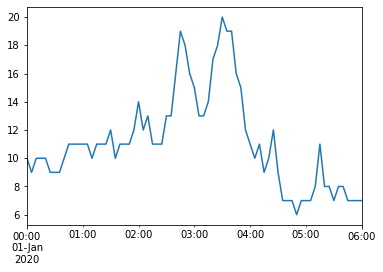

In [12]:
df['Total Cloud Cover [%]'].plot()

In [13]:
order = (1,1,0)

In [14]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(endog=df['Total Cloud Cover [%]'],order=order,seasonal_order=(0,0,0,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
history = model.fit()
print(history.summary())

                             Statespace Model Results                            
Dep. Variable:     Total Cloud Cover [%]   No. Observations:                   73
Model:                  SARIMAX(1, 1, 0)   Log Likelihood                -126.803
Date:                   Sun, 07 Nov 2021   AIC                            257.606
Time:                           09:42:49   BIC                            262.159
Sample:                       01-01-2020   HQIC                           259.419
                            - 01-01-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0417      0.103      0.404      0.686      -0.161       0.244
sigma2         1.9826      0.331      5.989      0.000       1.334       2.631
Ljung-Box (Q):              

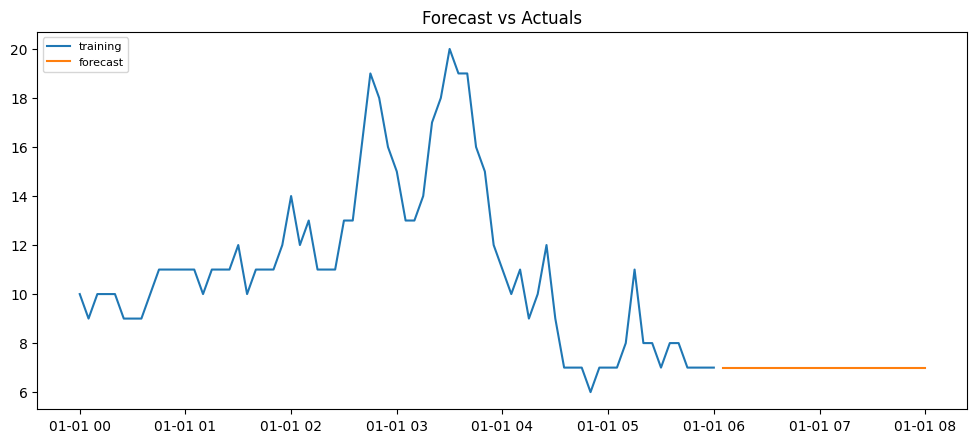

In [16]:
fc = history.forecast(24)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Total Cloud Cover [%]'], label='training')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
fc

2020-01-01 06:05:00    7.0
2020-01-01 06:10:00    7.0
2020-01-01 06:15:00    7.0
2020-01-01 06:20:00    7.0
2020-01-01 06:25:00    7.0
2020-01-01 06:30:00    7.0
2020-01-01 06:35:00    7.0
2020-01-01 06:40:00    7.0
2020-01-01 06:45:00    7.0
2020-01-01 06:50:00    7.0
2020-01-01 06:55:00    7.0
2020-01-01 07:00:00    7.0
2020-01-01 07:05:00    7.0
2020-01-01 07:10:00    7.0
2020-01-01 07:15:00    7.0
2020-01-01 07:20:00    7.0
2020-01-01 07:25:00    7.0
2020-01-01 07:30:00    7.0
2020-01-01 07:35:00    7.0
2020-01-01 07:40:00    7.0
2020-01-01 07:45:00    7.0
2020-01-01 07:50:00    7.0
2020-01-01 07:55:00    7.0
2020-01-01 08:00:00    7.0
Freq: 5T, dtype: float64

In [18]:
for i in range(1,301):
  path = 'test/'+str(i)+'/weather_data.csv'
  df = pd.read_csv(path)
  todays_date = datetime.now().date()
  index = pd.date_range('2020-01-01', periods=361, freq='1min')
  df = df.set_index(index[0:361])
  df.drop('Time [Mins]',inplace=True,axis=1)
  df = df.resample('5min').min()
  df['Total Cloud Cover [%]'] = [np.NaN if (per < 0 or per > 100) else per for per in df['Total Cloud Cover [%]']]
  df['Total Cloud Cover [%]'] = df['Total Cloud Cover [%]'].interpolate(method='polynomial', order=2)
  df['Total Cloud Cover [%]'].fillna(df['Total Cloud Cover [%]'].max(),inplace = True)
  model = sm.tsa.statespace.SARIMAX(endog=df['Total Cloud Cover [%]'],order=order,seasonal_order=(0,0,0,0))
  history = model.fit()
  fc = history.forecast(24)
  tdf.loc[i,'30_min_horizon'] = fc['2020-01-01 06:30:00']
  tdf.loc[i,'60_min_horizon'] = fc['2020-01-01 07:00:00']
  tdf.loc[i,'90_min_horizon'] = fc['2020-01-01 07:30:00']
  tdf.loc[i,'120_min_horizon'] = fc['2020-01-01 08:00:00']

In [19]:
tdf

,30_min_horizon,60_min_horizon,90_min_horizon,120_min_horizon
scenario_set,,,,
1,99.925522,99.937403,99.937556,99.937558
2,37.071549,37.071419,37.071419,37.071419
3,97.884258,97.884258,97.884258,97.884258
4,53.000000,53.000000,53.000000,53.000000
5,20.000000,20.000000,20.000000,20.000000
...,...,...,...,...
296,10.000000,10.000000,10.000000,10.000000
297,53.198312,53.198311,53.198311,53.198311
298,13.027627,13.027627,13.027627,13.027627


In [20]:
tdf['30_min_horizon'] = [100 if (per > 100) else per for per in tdf['30_min_horizon']]
tdf['60_min_horizon'] = [100 if (per > 100) else per for per in tdf['60_min_horizon']]
tdf['90_min_horizon'] = [100 if (per > 100) else per for per in tdf['90_min_horizon']]
tdf['120_min_horizon'] = [100 if (per > 100) else per for per in tdf['120_min_horizon']]

In [21]:
tdf.describe()

,30_min_horizon,60_min_horizon,90_min_horizon,120_min_horizon
count,300.000000,300.000000,300.000000,300.000000
mean,57.111548,57.123332,57.117425,57.113478
std,34.390096,34.404811,34.400959,34.398079
min,3.967669,3.967669,3.967669,3.967669
25%,20.000000,20.000000,20.000000,20.000000
50%,57.412201,57.413798,57.413800,57.413800
75%,94.000000,94.000000,94.000000,94.000000
max,100.000000,100.000000,100.000000,100.000000


In [22]:
tdf.to_csv('sol.csv')